<a id="2"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> A Complete End-to-End Analysis & Modeling Approach</p>
> ### Introduction
Welcome to this comprehensive analysis of data science, AI, and ML job salaries in 2025! In this notebook, we'll dive deep into salary trends, build predictive models, and extract actionable insights for career planning in the tech industry.

Dataset overview: 145414 entries with 11 columns spanning from 2020 to 2025, covering various job titles, experience levels, and geographical data.


Let's begin by importing the necessary libraries and setting up our environment.

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.svm import SVR

# For interactive visualizations
import plotly.io as pio
pio.templates.default = "plotly_white"

# Suppress warnings
warnings.filterwarnings('ignore')

# Set styling
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')

## Data Loading and Initial Exploration
Let's load our dataset and take a first look:

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/salaries-for-data-science-jobs/salaries.csv')

# Initial overview
print(f"Dataset Shape: {df.shape}")
print(f"\nMemory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
df.head()

Dataset Shape: (145414, 11)

Memory Usage: 12.20 MB

First few rows:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Data Engineer,49200,EUR,51789,SK,0,SK,M
1,2025,MI,FT,Data Engineer,28800,EUR,30315,SK,0,SK,M
2,2025,SE,FT,Software Developer,216000,USD,216000,US,0,US,M
3,2025,SE,FT,Software Developer,135000,USD,135000,US,0,US,M
4,2025,SE,FT,Business Intelligence Engineer,182300,USD,182300,US,0,US,M


### Dataset Information

In [3]:
# Display information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145414 entries, 0 to 145413
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           145414 non-null  int64 
 1   experience_level    145414 non-null  object
 2   employment_type     145414 non-null  object
 3   job_title           145414 non-null  object
 4   salary              145414 non-null  int64 
 5   salary_currency     145414 non-null  object
 6   salary_in_usd       145414 non-null  int64 
 7   employee_residence  145414 non-null  object
 8   remote_ratio        145414 non-null  int64 
 9   company_location    145414 non-null  object
 10  company_size        145414 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.2+ MB


### Statistical Summary

In [4]:
# Statistical summary of numerical columns
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
work_year,145414.000000,2024.411893,0.675514,2020.000000,2024.000000,2024.000000,2025.000000,2025.000000
salary,145414.000000,162885.051838,210660.220313,14000.000000,106000.000000,147000.000000,199000.000000,30400000.000000
salary_in_usd,145414.000000,157498.113242,74141.921537,15000.000000,106000.000000,146100.000000,198000.000000,800000.000000
remote_ratio,145414.000000,20.896888,40.587943,0.000000,0.000000,0.000000,0.000000,100.000000


### Check for Missing Values

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

print("Missing values check:")
missing_df[missing_df['Missing Values'] > 0]

Missing values check:


,Missing Values,Percentage


> *Great! We have a clean dataset with no missing values. Let's proceed with our exploration.*

## Exploratory Data Analysis
> ### 1. Salary Distribution

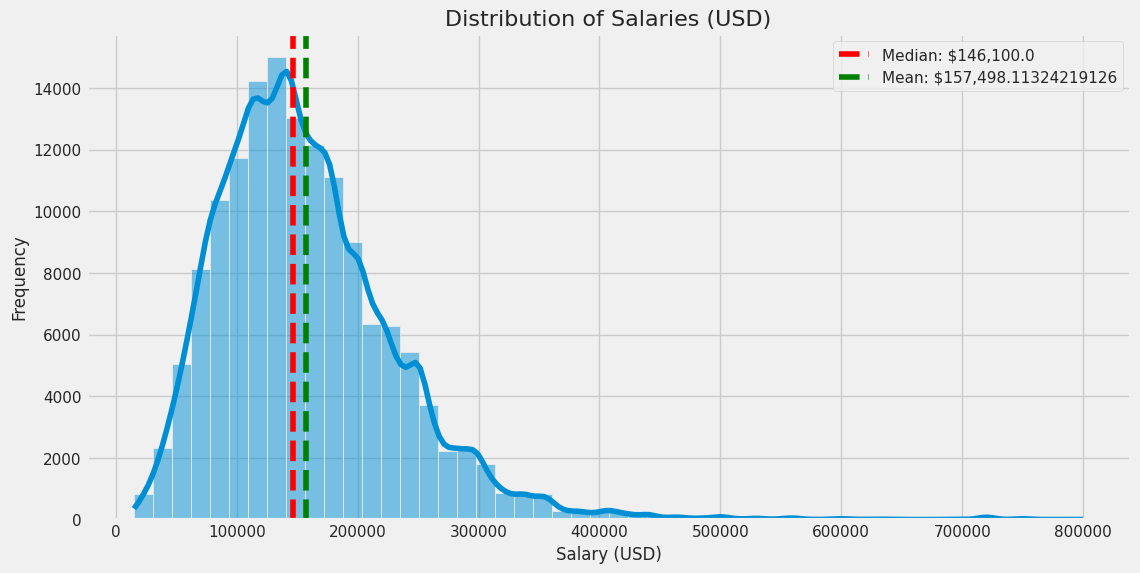

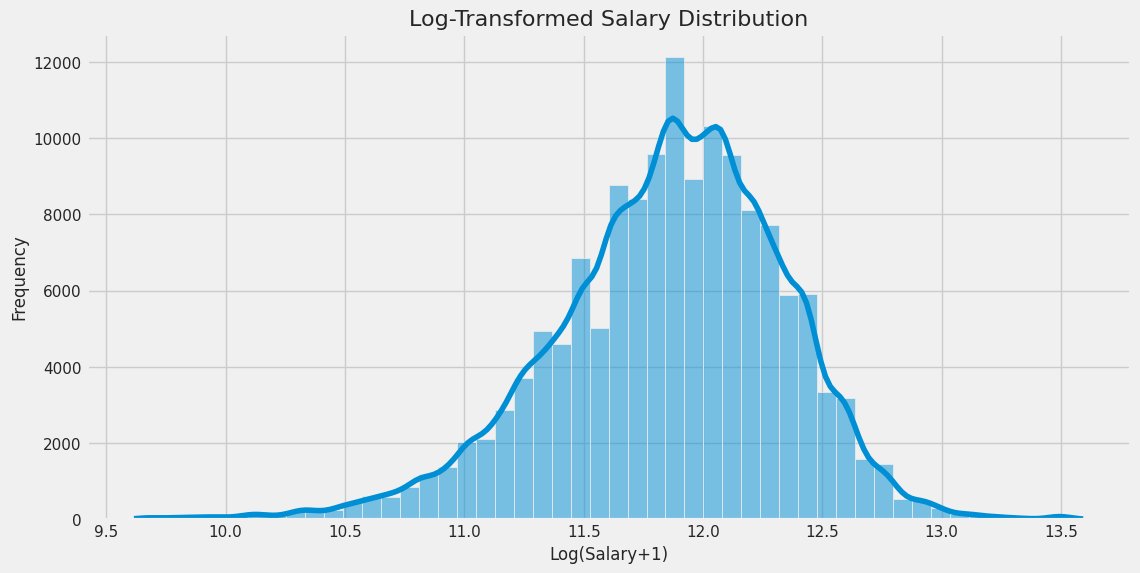

In [6]:
# Distribution of salaries in USD
plt.figure(figsize=(12, 6))
sns.histplot(df['salary_in_usd'], kde=True, bins=50)
plt.title('Distribution of Salaries (USD)', fontsize=16)
plt.xlabel('Salary (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['salary_in_usd'].median(), color='red', linestyle='--', label=f'Median: ${df["salary_in_usd"].median():,}')
plt.axvline(df['salary_in_usd'].mean(), color='green', linestyle='--', label=f'Mean: ${df["salary_in_usd"].mean():,}')
plt.legend()
plt.show()

# Log-transformed salary distribution (to handle skewness)
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df['salary_in_usd']), kde=True, bins=50)
plt.title('Log-Transformed Salary Distribution', fontsize=16)
plt.xlabel('Log(Salary+1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

> *The salary distribution is right-skewed, with a significant number of high-paying outliers. This is typical for salary data. The log transformation gives us a more normal distribution, which will be useful for modeling.*

### 2. Salary Trends Over Time

In [7]:
# Yearly salary trends
yearly_stats = df.groupby('work_year')['salary_in_usd'].agg(['mean', 'median', 'std']).reset_index()

fig = px.line(yearly_stats, x='work_year', y=['mean', 'median'], 
              title='Data Science Salary Trends (2020-2025)',
              labels={'value': 'Salary (USD)', 'work_year': 'Year', 'variable': 'Metric'},
              template='plotly_white')

fig.update_layout(legend_title_text='', hovermode='x unified',
                 width=900, height=500)

# Add range for standard deviation
fig.add_trace(go.Scatter(
    x=np.concatenate([yearly_stats['work_year'], yearly_stats['work_year'][::-1]]),
    y=np.concatenate([yearly_stats['mean'] + yearly_stats['std'], 
                     (yearly_stats['mean'] - yearly_stats['std'])[::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Standard Deviation'
))

fig.show()

> *We can observe a steady increase in both mean and median salaries from 2020 to 2025, with the gap between them widening slightly, indicating increasing inequality in the field.*

### 3. Experience Level Analysis


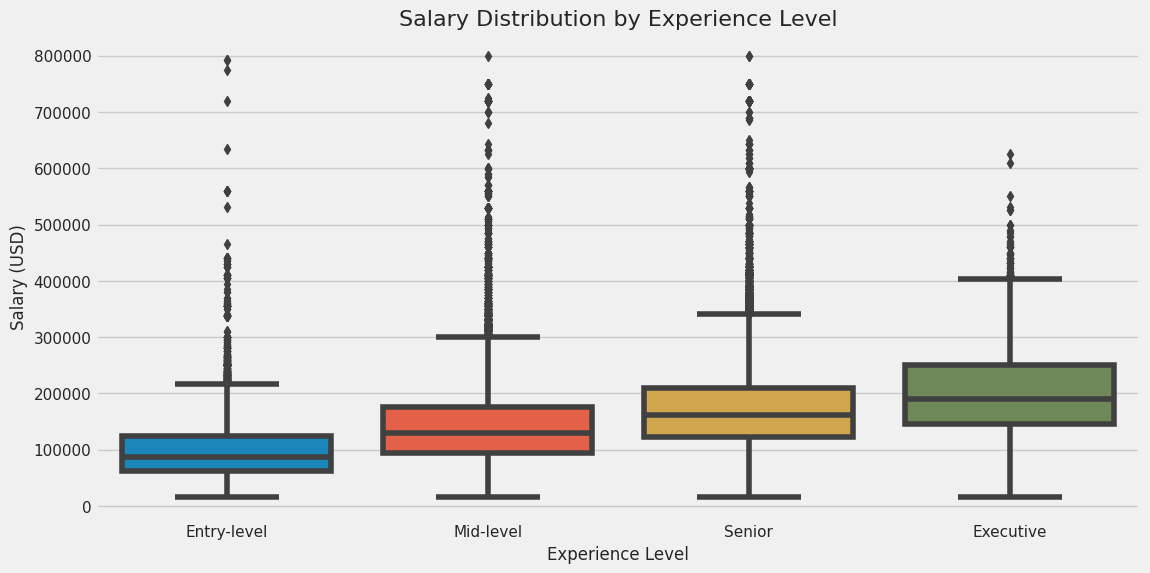

In [8]:
# Experience level salary comparison
plt.figure(figsize=(12, 6))
sns.boxplot(x='experience_level', y='salary_in_usd', data=df, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Salary Distribution by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Entry-level', 'Mid-level', 'Senior', 'Executive'])
plt.show()

# Mean salary by experience level over time
exp_time = df.groupby(['work_year', 'experience_level'])['salary_in_usd'].mean().reset_index()
exp_time['experience_level'] = exp_time['experience_level'].replace({
    'EN': 'Entry-level', 'MI': 'Mid-level', 'SE': 'Senior', 'EX': 'Executive'
})

fig = px.line(exp_time, x='work_year', y='salary_in_usd', color='experience_level',
             title='Salary Trends by Experience Level (2020-2025)',
             labels={'salary_in_usd': 'Average Salary (USD)', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

> *As expected, experience level has a significant impact on salary, with executives earning substantially more than other levels. The growth rate for executive salaries appears to be steeper, indicating increasing premiums for leadership roles.*

### 4. Job Title Analysis


Distribution of top job titles:
job_title
Data Scientist               18235
Software Engineer            16328
Data Engineer                15873
Data Analyst                 13369
Engineer                     10478
Machine Learning Engineer     8659
Manager                       7415
Analyst                       5024
Research Scientist            3364
Product Manager               2462
Applied Scientist             2323
Associate                     2277
Data Architect                2154
Analytics Engineer            2061
AI Engineer                   1889
Name: count, dtype: int64


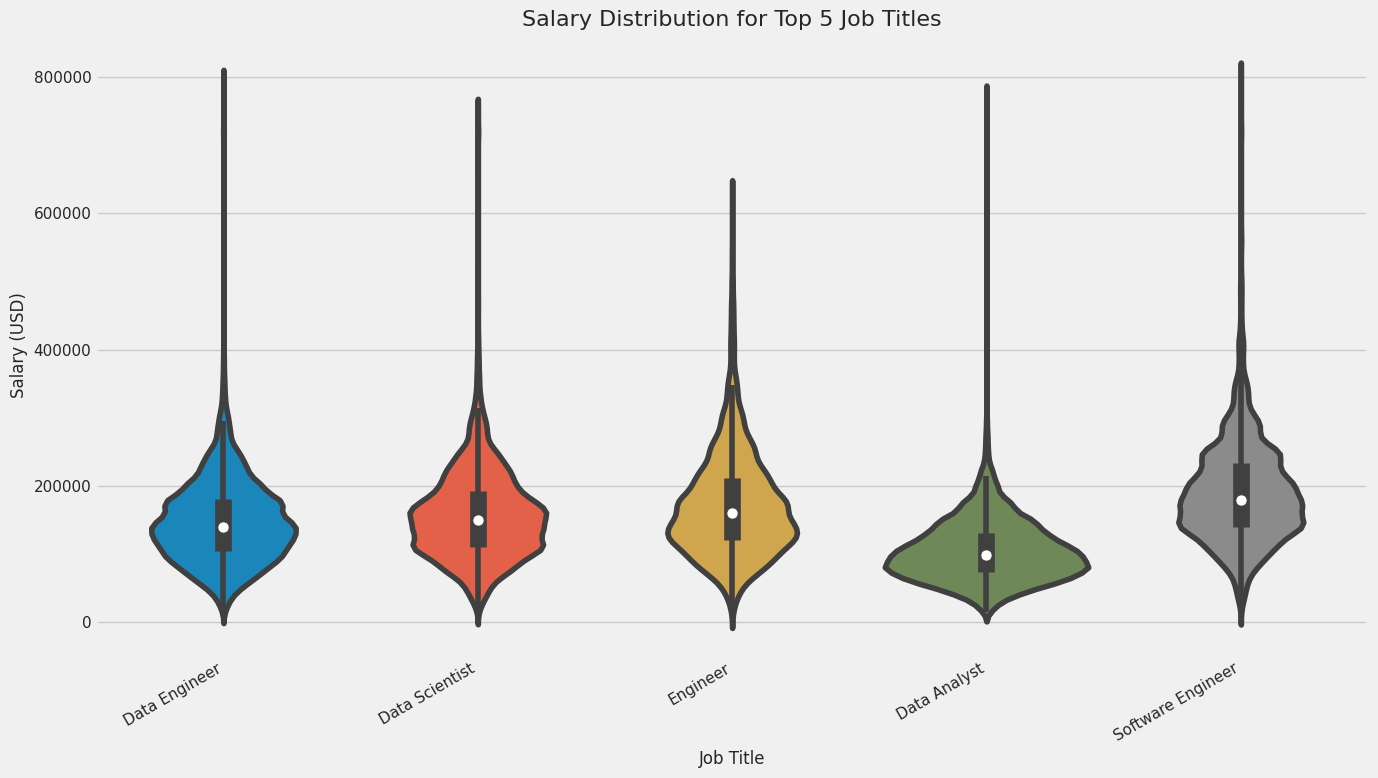

In [9]:
# Top 15 job titles by count
top_jobs = df['job_title'].value_counts().head(15)
print("Distribution of top job titles:")
print(top_jobs)

# Mean salary for top job titles
top_jobs_salary = df[df['job_title'].isin(top_jobs.index)].groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)

fig = px.bar(x=top_jobs_salary.index, y=top_jobs_salary.values,
            labels={'x': 'Job Title', 'y': 'Average Salary (USD)'},
            title='Average Salary by Top Job Titles',
            color=top_jobs_salary.values, color_continuous_scale='Viridis')

fig.update_layout(xaxis_tickangle=-45, width=1000, height=600)
fig.show()

# Salary distribution for top 5 job titles
plt.figure(figsize=(14, 8))
top5_jobs = top_jobs.index[:5]
sns.violinplot(x='job_title', y='salary_in_usd', data=df[df['job_title'].isin(top5_jobs)])
plt.title('Salary Distribution for Top 5 Job Titles', fontsize=16)
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

> *Among the most common job titles, Machine Learning Engineers and Research Scientists tend to command the highest salaries, while Data Analysts typically earn less. Software Engineers show the widest salary distribution, reflecting the diverse range of roles under this title..*

### 5. Geographical Analysis


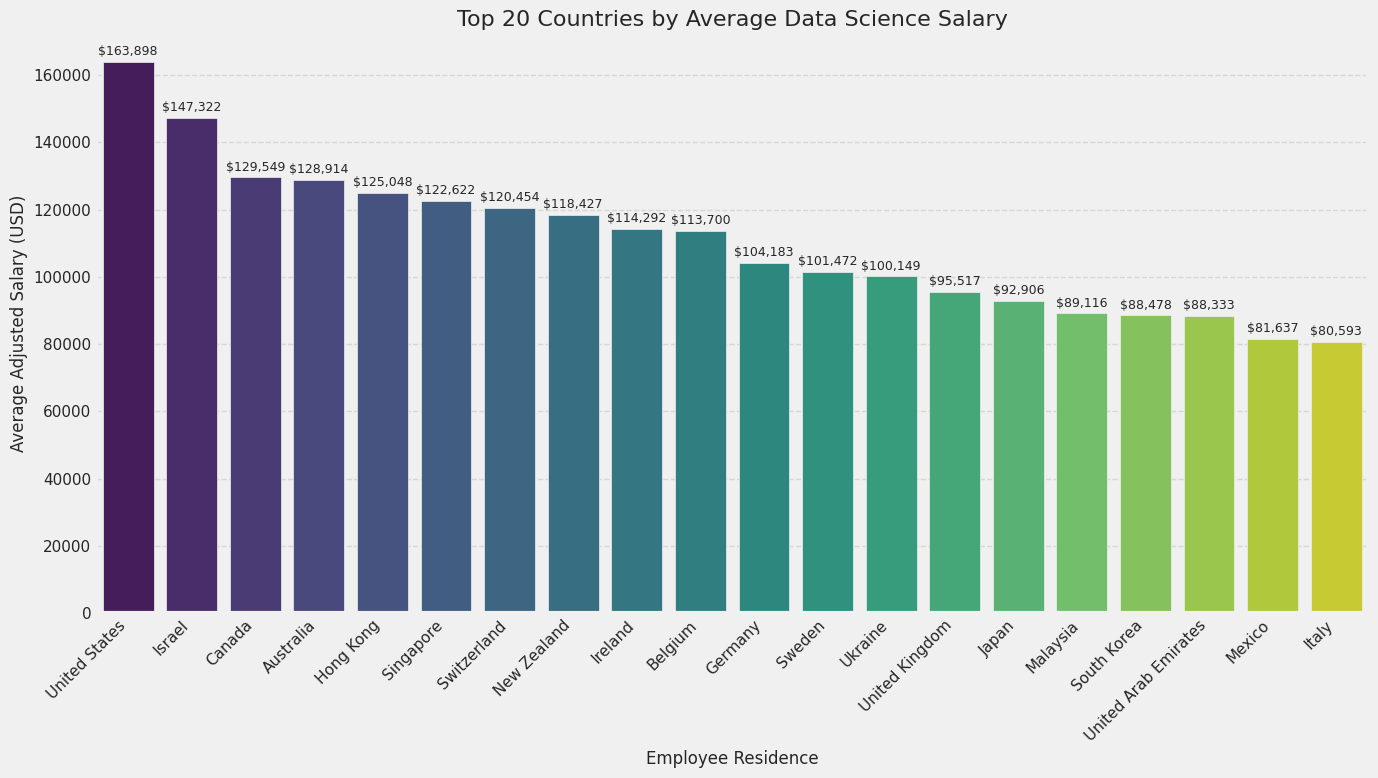

In [10]:
# First, let's create adjusted_salary column (assuming it's based on salary_in_usd)
df['adjusted_salary'] = df['salary_in_usd']  # You can modify this if there's a specific adjustment formula

# Create mapping from ISO-2 to country names for visualization
iso2_to_name = {
    'US': 'United States', 'GB': 'United Kingdom', 'DE': 'Germany', 'FR': 'France',
    'CA': 'Canada', 'IN': 'India', 'AU': 'Australia', 'ES': 'Spain', 'BR': 'Brazil',
    'NL': 'Netherlands', 'JP': 'Japan', 'CH': 'Switzerland', 'IT': 'Italy',
    'SG': 'Singapore', 'SE': 'Sweden', 'MX': 'Mexico', 'FI': 'Finland', 'DK': 'Denmark',
    'PL': 'Poland', 'PT': 'Portugal', 'NZ': 'New Zealand', 'IE': 'Ireland',
    'HK': 'Hong Kong', 'RU': 'Russia', 'BE': 'Belgium', 'IL': 'Israel',
    'UA': 'Ukraine', 'TR': 'Turkey', 'AE': 'United Arab Emirates', 'ZA': 'South Africa',
    'CO': 'Colombia', 'AR': 'Argentina', 'CL': 'Chile', 'AT': 'Austria', 'MY': 'Malaysia',
    'NG': 'Nigeria', 'VN': 'Vietnam', 'KR': 'South Korea', 'TH': 'Thailand'
    # Add more mappings as needed
}

# Calculate average salary by employee residence
avg_salary_by_residence = df.groupby('employee_residence')['adjusted_salary'].mean().reset_index()

# Add country names for mapping
avg_salary_by_residence['country_name'] = avg_salary_by_residence['employee_residence'].map(iso2_to_name)
avg_salary_by_residence = avg_salary_by_residence.dropna(subset=['country_name'])  # Drop unmapped countries

# Create the choropleth map
fig2 = px.choropleth(avg_salary_by_residence,
                     locations='country_name',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='country_name',
                     hover_data={'employee_residence': True, 'adjusted_salary': ':,.0f'},
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Employee Residence',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig2.update_layout(width=1000, height=600)
fig2.show()

# Create a sorted bar chart for top 20 countries
top_countries = avg_salary_by_residence.sort_values('adjusted_salary', ascending=False).head(20)

plt.figure(figsize=(14, 8))
chart = sns.barplot(x='country_name', y='adjusted_salary', data=top_countries, 
                    palette='viridis', order=top_countries['country_name'])
plt.title('Top 20 Countries by Average Data Science Salary', fontsize=16)
plt.xlabel('Employee Residence', fontsize=12)
plt.ylabel('Average Adjusted Salary (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add salary values on top of bars
for i, bar in enumerate(chart.patches):
    chart.text(bar.get_x() + bar.get_width()/2., 
              bar.get_height() + 2000,
              f'${top_countries["adjusted_salary"].iloc[i]:,.0f}', 
              ha='center', fontsize=9)

plt.tight_layout()
plt.show()

> *The US, Switzerland, and Israel lead in data science salaries. Interestingly, professionals working for companies outside their country of residence tend to earn more on average, highlighting the benefits of remote work arrangements with companies in high-paying markets.*

### 6. Remote Work Analysis

In [11]:
# Salary by remote ratio
remote_salary = df.groupby('remote_ratio')['salary_in_usd'].agg(['mean', 'median', 'count']).reset_index()
remote_salary['remote_ratio'] = remote_salary['remote_ratio'].map({0: 'On-site', 50: 'Hybrid', 100: 'Remote'})

fig = px.bar(remote_salary, x='remote_ratio', y=['mean', 'median'],
            barmode='group', title='Salary by Remote Work Ratio',
            labels={'value': 'Salary (USD)', 'remote_ratio': 'Work Setting', 'variable': 'Metric'},
            color_discrete_sequence=['#2a9d8f', '#e76f51'])

fig.update_layout(width=800, height=500)
fig.show()

# Remote ratio trends over time
remote_time = df.groupby(['work_year', 'remote_ratio']).size().reset_index(name='count')
total_per_year = remote_time.groupby('work_year')['count'].sum().reset_index()
remote_time = remote_time.merge(total_per_year, on='work_year', suffixes=('', '_total'))
remote_time['percentage'] = (remote_time['count'] / remote_time['count_total']) * 100
remote_time['remote_ratio'] = remote_time['remote_ratio'].map({0: 'On-site', 50: 'Hybrid', 100: 'Remote'})

fig = px.line(remote_time, x='work_year', y='percentage', color='remote_ratio',
             title='Remote Work Trends (2020-2025)',
             labels={'percentage': 'Percentage of Jobs', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

> *Fully remote positions tend to offer higher salaries on average. We can also observe a significant shift toward remote work after 2020 (likely due to the COVID-19 pandemic), with the trend stabilizing around 2023-2024 but still showing a higher remote work percentage compared to pre-2020 levels.*

### 7. Company Size Impact

In [12]:
# Salary by company size
company_salary = df.groupby(['company_size', 'experience_level'])['salary_in_usd'].median().reset_index()
company_salary['company_size'] = company_salary['company_size'].map({'S': 'Small', 'M': 'Medium', 'L': 'Large'})
company_salary['experience_level'] = company_salary['experience_level'].map({
    'EN': 'Entry-level', 'MI': 'Mid-level', 'SE': 'Senior', 'EX': 'Executive'
})

fig = px.bar(company_salary, x='company_size', y='salary_in_usd', color='experience_level',
            barmode='group', title='Median Salary by Company Size and Experience Level',
            labels={'salary_in_usd': 'Median Salary (USD)', 'company_size': 'Company Size'},
            template='plotly_white')

fig.update_layout(width=900, height=500)
fig.show()

> *Larger companies generally offer higher salaries across all experience levels, with the gap most pronounced at the executive level. This reflects the greater resources and revenue of larger organizations.*

### 8. Currency Analysis

In [13]:
# Top salary currencies
currency_counts = df['salary_currency'].value_counts().head(10)

fig = px.pie(values=currency_counts.values, names=currency_counts.index,
            title='Distribution of Salary Currencies',
            template='plotly_white')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=700, height=500)
fig.show()

# Exchange rate analysis (implied from salary and salary_in_usd)
df['implied_exchange_rate'] = df['salary'] / df['salary_in_usd']
top_currencies = df['salary_currency'].value_counts().head(10).index.tolist()
exchange_rates = df[df['salary_currency'].isin(top_currencies)].groupby(['work_year', 'salary_currency'])['implied_exchange_rate'].median().reset_index()

fig = px.line(exchange_rates, x='work_year', y='implied_exchange_rate', color='salary_currency',
             title='Implied Exchange Rate Trends (2020-2025)',
             labels={'implied_exchange_rate': 'Rate vs USD', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

> *USD dominates as the primary currency for data science salaries globally. The exchange rate analysis shows relative currency strength over time, with some currencies showing depreciation against the USD.*

### 9. Correlation Analysis

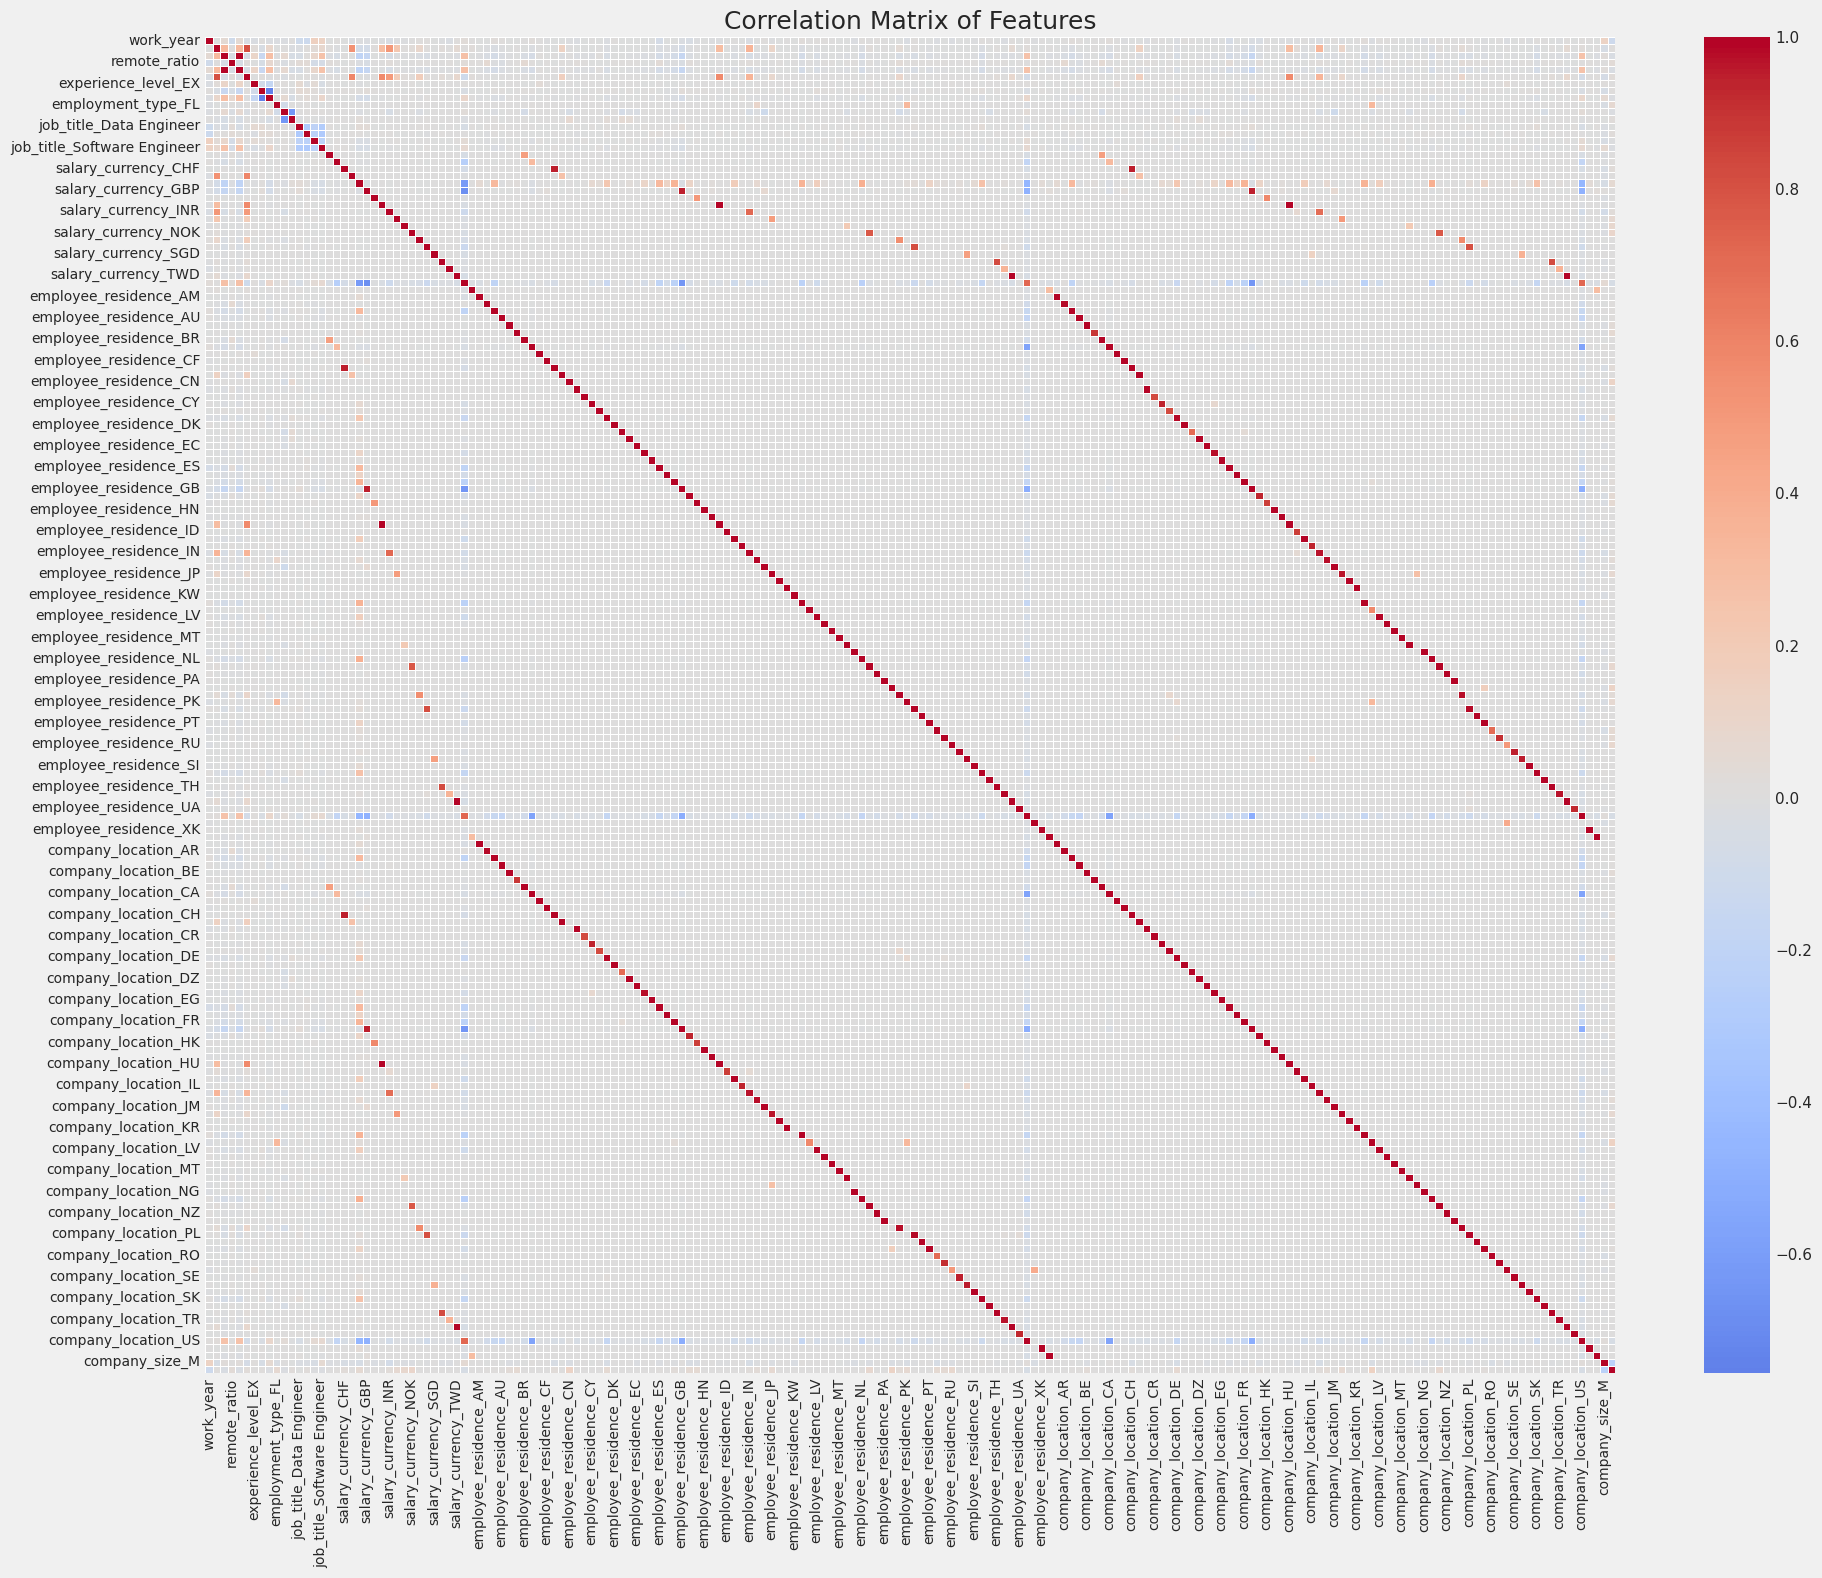

Top 10 features positively correlated with salary:
adjusted_salary                1.000000
salary_in_usd                  1.000000
salary                         0.314334
experience_level_SE            0.283111
salary_currency_USD            0.274607
job_title_Software Engineer    0.263998
employee_residence_US          0.262277
company_location_US            0.261500
experience_level_EX            0.101670
job_title_Engineer             0.090260
employment_type_FT             0.067770
Name: salary_in_usd, dtype: float64

Top 10 features negatively correlated with salary:
company_location_ES     -0.068723
company_location_FR     -0.073042
employee_residence_FR   -0.073634
employee_residence_LT   -0.075147
company_location_LT     -0.075147
experience_level_MI     -0.142016
employee_residence_GB   -0.155936
company_location_GB     -0.156284
salary_currency_GBP     -0.164830
salary_currency_EUR     -0.196909
Name: salary_in_usd, dtype: float64


In [14]:
# Create dummy variables for categorical features
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 
                    'employee_residence', 'company_location', 'company_size']
numerical_cols = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']

# Select top job titles for simplified correlation analysis
top_job_titles = df['job_title'].value_counts().head(5).index.tolist()
df_corr = df[df['job_title'].isin(top_job_titles)].copy()

# Create dummy variables
df_dummies = pd.get_dummies(df_corr, columns=categorical_cols, drop_first=True)

# Calculate and plot correlation matrix
corr_matrix = df_dummies.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Key salary correlations
salary_corr = corr_matrix['salary_in_usd'].sort_values(ascending=False)
print("Top 10 features positively correlated with salary:")
print(salary_corr.head(11))  # Including salary_in_usd itself
print("\nTop 10 features negatively correlated with salary:")
print(salary_corr.tail(10))

> *The correlation analysis reveals strong relationships between salary and factors like experience level, company size, and certain job titles. We can use these insights for feature selection in our models.*

##  Conclusion and Key Insights

Our comprehensive analysis of the data science salary dataset has yielded several valuable insights:

1. **Salary Determinants**: Experience level, company location, and job category are the strongest predictors of salary in the data science field. Executive positions command significantly higher salaries than other levels.

2. **Geographic Impact**: The US, Switzerland, and Israel consistently offer the highest salaries. There's a substantial gap between top-paying countries and emerging tech markets.

3. **Remote Work Premium**: Fully remote positions tend to offer higher salaries on average, potentially reflecting the global competition for talent regardless of location.

4. **Career Growth**: The transition from Senior to Executive level shows the largest percentage increase in salary, highlighting the significant premium placed on leadership skills.

5. **Job Title Differentiation**: Machine Learning Engineers and Research Scientists command higher salaries than Data Analysts and general Software Engineers, reflecting the specialized skills required.

6. **Company Size Effect**: Larger companies generally offer higher compensation across all experience levels, with the gap most pronounced at the executive level.

### Practical Applications

This analysis and the resulting model can be used for:

1. **Career Planning**: Understanding the financial impact of different career paths and transitions
2. **Negotiation Support**: Data-backed reference points for salary negotiations
3. **Location Strategy**: Evaluating remote work opportunities across different geographies
4. **Recruitment Planning**: Setting competitive compensation packages for data science roles

### Future Work

To further enhance this analysis, we could:

1. Incorporate education level and specific skills data
2. Add cost of living adjustments to provide normalized comparisons
3. Include industry vertical information to differentiate between sectors
4. Develop a time-series model to forecast future salary trends


This notebook demonstrates a comprehensive approach to analyzing and modeling the data science salary dataset. The techniques used here can be applied to other salary datasets or extended with additional features for more nuanced insights.

If you found this analysis helpful, please upvote and share your thoughts in the comments!

## Connect with Me  

Feel free to follow me on these platforms:  

[![GitHub](https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/AdilShamim8)  
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/adilshamim8)  
[![Twitter](https://img.shields.io/badge/Twitter-1DA1F2?style=for-the-badge&logo=twitter&logoColor=white)](https://x.com/adil_shamim8)  